# COMP4187: Parallel Scientific Computing II

## Anne Reinarz
## anne.k.reinarz@durham.ac.uk

# Organisation

- We are moving on to the next notebook: finite-difference-II.ipynb


## Summary

Last week we discussed:
- 1D finite differencing schemes of "arbitrary" order and how to derive them
- Boundary conditions
- Error norms

## This week

- Some notes on performance
- Moving from 1D to 2D

## The remaining weeks

- We look at multigrid solvers

## Matrix representation of operators

We saw briefly that we can represent finite difference operators as matrices. Let's look at this in a bit more detail.

We need to provide an ordering of all of the degrees of freedom (dofs) in our finite difference discretisation. 

In one dimension, we order the points in the domain from left to right and use a single index:

$$
x_0 < x_1 < \dots < x_{n-1}
$$

and so we have a single index for all the points $i = [0, 1, \dots, n-1]$. 

We can therefore represent our function $u(x)$ discretised at the points $\{x_i\}$ as a vector in $\mathbb{R}^n$

$$
U = \begin{bmatrix} u_0 \\ u_1 \\ \vdots \\ u_{n-1} \end{bmatrix}
$$

and similarly with the right hand side $f(x)$.

The differencing operators *combine* entries from $U$ linearly to produce a new vector $D U$. Since this operation is linear, we can represent it as a matrix

$$
D : \mathbb{R}^n \to \mathbb{R}^n
$$

which takes in a vector $U$ and spits out a new vector representing the action of the differencing operator on $U$.


For example, the left-looking operator $D_- u_i = \frac{u_i - u_{i-1}}{h}$ uses, at each point $i$ values from points $i$ and $i-1$. On a grid with 4 points, this can be represented as the matrix

$$
D_- = \frac{1}{h}
\begin{bmatrix}
1 & 0 & 0 & 0\\
-1 & 1 & 0 & 0\\
0 & -1 & 1 & 0\\
0 & 0 & -1 & 1
\end{bmatrix}.
$$

Similarly, the centered difference approximation of $\frac{\text{d}^2}{\text{d} x^2}$, $$D^2 u_i = \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$$ can be written as?

$$
D^2 = \frac{1}{h^2}
\begin{bmatrix}
...
\end{bmatrix}.
$$

Similarly, the centered difference approximation of $\frac{\text{d}^2}{\text{d} x^2}$, $D^2 u_i = \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$ can be written as:

$$
D^2 = \frac{1}{h^2}
\begin{bmatrix}
-2 & 1 & 0 & 0\\
1 & -2 & 1 & 0\\
0 & 1 & -2 & 1\\
0 & 0 & 1 & -2
\end{bmatrix}.
$$

## Questions

- What is the complexity of our computation?
- What component is the computational bottleneck?
- Can we fix this?

### "Matrix-free" implementation

If we only never need to apply the differencing operator, it might make sense (memory or efficiency, for example) to just provide a function which computes the matrix-vector multiplication without storing the matrix. Let's see this in action.

In [6]:
%matplotlib notebook
from matplotlib import pyplot
import numpy
pyplot.style.use('ggplot')

def dminus(u, h):
    n, = u.shape
    du = numpy.zeros_like(u)
    for i in range(n):
        if i == 0:
            du[i] = 1/h * u[i]
        else:
            du[i] = 1/h * (u[i] - u[i-1])
    return du

def dminusop(u, h):
    n, = u.shape
    D = numpy.eye(n) - numpy.diag(numpy.full(n-1, 1), k=-1)
    D *= 1/h
    return D

In [8]:
n = 10
u = numpy.random.rand(n)
h = 1/n
dminus(u, h)

array([ 7.22907919, -2.50275051,  3.50441452, -7.64287468,  7.82952239,
       -4.99903039,  6.51329753, -5.71957996, -3.07500753,  7.00186152])

In [4]:
D = dminusop(u, h)
D @ u

array([ 2.97007287,  0.17198709,  2.9514533 ,  0.50214123, -0.74004476,
        1.86665255, -1.32913431, -1.92595235,  2.58040136, -3.70939837])

## Which one is faster?

- Let's have a go with a bigger grid. We can use notebook "magic" %%timeit to time the execution of a cell.

In [5]:
n = 10000
u = numpy.random.rand(n)
h = 1/n

In [9]:
%%timeit
dminus(u, h)

13.1 µs ± 788 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
D = dminusop(u, h)

In [8]:
%%timeit
D @ u

65.3 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Perhaps surprisingly, the python loops are faster than the numpy matrix-vector product.

This is likely because the numpy matrix is 10000 x 10000 and dense (and we do a lot of work multiplying by zero). 
We should probably use a *sparse* matrix.

We can also attempt to speed up the loop by using numba:

In [11]:
import numba

@numba.jit
def dminus_compiled(u, h):
    n, = u.shape
    du = numpy.zeros_like(u)
    for i in range(n):
        if i == 0:
            du[i] = 1/h * u[i]
        else:
            du[i] = 1/h * (u[i] - u[i-1])
    return du

In [12]:
%%timeit
dminus_compiled(u, h)

The slowest run took 14.60 times longer than the fastest. This could mean that an intermediate result is being cached.
3.95 µs ± 5.98 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Outcome

Nearly a 500x speedup. This doesn't work for all functions, but if you have code with loops and numpy arrays, it's probably worth a shot.

## Numba

- Numba is the Python JIT compiler, see [numba](https://numba.pydata.org) or [docs](https://numba.readthedocs.io/en/stable/user/5minguide.html)
- Install via `pip install numba`.

- Numba works best on code that uses only NumPy arrays and functions, and loops.
- For most features, just add a decorator to your function, e.g. `@numba.jit`
- It is compiled to machine code via LLVM

## 2D finite differences

Now, finally, let's look at finite differences in 2D. We remind ourselves of the differential operators we might encounter. Rather than just a derivative in the $x$ direction, we can take derivatives of a function in both $x$ and $y$.

$$
\begin{aligned}
\partial_x u &= \frac{\partial u(x, y)}{\partial x}\\
\partial_y u &= \frac{\partial u(x, y)}{\partial y}
\end{aligned}.
$$

### Gradient

For a scalar $u(x, y)$ the 2D gradient is a vector

$$
\nabla u(x, y) := \begin{bmatrix} \partial_x u \\ \partial_y u \end{bmatrix}.
$$


### Divergence

For a vector $\vec{w}(x, y) = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$, the divergence is a scalar

$$
\nabla \cdot \vec{w} = \partial_x w_0 + \partial_y w_1.
$$

### Laplacian

For a scalar $u(x, y)$ the Laplacian is a scalar

$$
\nabla^2 u(x, y) := \nabla \cdot \nabla u(x, y) = \partial_x^2 u + \partial_y^2 u.
$$


### Finite difference operators

- As usual, we need some domain $\Omega$ in which we will solve the problem. 
- Given some domain, we need to choose a way of specifying it, and ordering the degrees of freedom. 

#### This is very fiddly for anything other than coordinate aligned rectangular domains (one of the major disadvantages of finite differences). As a result, all of the problems we will solve will be on squares and rectangles.

### Finite difference operators

Lets choose $$\Omega = (0, W) \times (0, H)$$

- We'll pick
    - $N_x$ points in the x-direction, and 
    - $N_y$ in the y-direction. 
    


### Finite difference operators

- We'll choose a typewriter ordering of degrees of freedom (bottom-to-top, left-to-right), so given an index $i$ in the x-direction and an index $j$ in the y-direction it represents the point
$$
(x, y) = (i h_x, j h_y)
$$

where

$$
\begin{aligned}
h_x = \frac{W}{N_x - 1}\text{ and }
h_y = \frac{H}{N_y - 1}\\
\end{aligned}
$$

and $i \in \{0, \dots, N_x - 1\}$, $j \in \{0, \dots, N_y - 1\}$.

### Finite difference operators

We will again represent our solution vectors as 1D vectors (remembering that we should plot them in 2D).

Let's write some code to encapsulate a domain and draw vectors.

In [13]:
from collections import namedtuple
Point = namedtuple("Point", ("x", "y"))

class Grid(object):
    def __init__(self, Nx, Ny, P0=Point(0,0), P1=Point(1,1)):
        X0, Y0 = P0
        X1, Y1 = P1
        self.W = X1 - X0
        self.H = Y1 - Y0
        self.Nx = Nx
        self.Ny = Ny
        x = numpy.linspace(X0, X1, self.Nx)
        y = numpy.linspace(Y0, Y1, self.Ny)
        self.XY = numpy.meshgrid(x, y, indexing="ij")
    
    @property
    def ndof(self):
        return self.Nx*self.Ny

    @property
    def hx(self):
        return self.W/(self.Nx - 1)
    
    @property
    def hy(self):
        return self.H/(self.Ny - 1)

    def alpha(self, i, j):
        return i*self.Ny + j

    def new_vector(self, components=1):
        vec = numpy.zeros(self.Nx*self.Ny*components, dtype=float)
        shape = (self.Nx, self.Ny)
        if components > 1:
            shape = shape + (components, )
        return vec.reshape(shape)
    
    def contourf(self, u, levels=11):
        U = u.reshape(self.Nx, self.Ny)
        pyplot.figure()
        
        pyplot.contourf(*self.XY, U, levels)
        pyplot.colorbar()
        
    def quiver(self, u, colour=None):
        U = u.reshape(self.Nx, self.Ny, 2)
        pyplot.figure()
        if colour is None:
            pyplot.quiver(*self.XY, U[..., 0], U[..., 1])
        else:
            pyplot.quiver(*self.XY, U[..., 0], U[..., 1], colour)

In [14]:
grid = Grid(17, 15, P0=Point(-2, -1), P1=Point(1, 1))

In [15]:
X, Y = grid.XY
u = grid.new_vector(components=2)
u[..., 0] = -Y
u[..., 1] = X

<IPython.core.display.Javascript object>


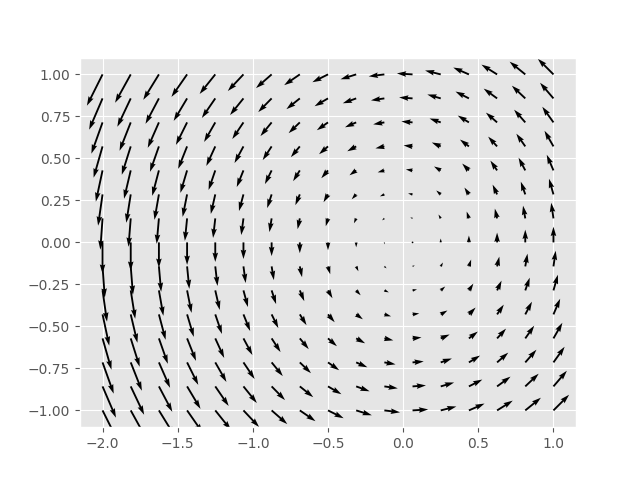

In [16]:
grid.quiver(u);

## Indexing

Notice how we return vectors that we can index with two indices (or three if we have a vector). For 2D indexing of a vector, I'll write (using roman indices):

$$
U_{i, j}
$$

to indicate the value at $(i h_x, j h_y)$.

We can translate these 2D indices into a 1D index to a flat vector. I'll use greek letters for these flat indices.

$$
\alpha(i, j) := i N_y + j
$$

## A 2D Model Problem


Now let's think about solving an equation, we'll start by solving the 2D Laplacian with Dirichlet conditions.

$$
\begin{aligned}
-\nabla^2 u &= f && \text{ on }\Omega = (0, 1) \times (0, 1)\\
         u &= g && \text{ on }\partial\Omega
\end{aligned}
$$

We'll pick $f = 8\pi^2\sin(2\pi x)\sin(2\pi y)$ and set $g = 0$.

## A 2D Model Problem


Since we're only doing things on axis-aligned domains, the derivatives decompose into directional derivatives, and so the 2D stencil is just the "sum" of the two 1D stencils for $\partial_x^2$ and $\partial_y^2$. 


#### Note: we must be careful to use the correct $h_x$ or $h_y$.



## A 2D Model Problem

So we have

$$
-\nabla^2 = \frac{1}{h_x^2} \begin{bmatrix} & & \\ -1 & 2 & -1 \\ & & \end{bmatrix} + \frac{1}{h_y^2} \begin{bmatrix} & -1 & \\ & 2 & \\ & -1 & \end{bmatrix}.
$$

Where this stencil notation is to be understood as being laid over the 2D grid. We will come to the indexing in a moment.

In [17]:
def laplacian(grid, f, g):
    ndof = grid.ndof
    A = numpy.zeros((ndof, ndof))
    X, Y = grid.XY
    u0 = g(X, Y)
    rhs = f(X, Y)
    stencilx = 1/grid.hx**2 * numpy.array([-1, 0, 2, 0, -1])
    stencily = 1/grid.hy**2 * numpy.array([0, -1, 2, -1, 0])
    stencil = stencilx + stencily
    for i in range(grid.Nx):
        for j in range(grid.Ny):
            row = grid.alpha(i, j)
            if i in (0, grid.Nx - 1) or j in {0, grid.Ny - 1}:
                # Dirichlet bc
                A[row, row] = 1
                rhs[i, j] = u0[i, j]
            else:
                cols = [grid.alpha(*ij) for ij in
                        [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]]
                A[row, cols] = stencil
    return A, rhs

In [18]:
grid = Grid(41, 41)
f = lambda x, y: 8*numpy.pi**2*numpy.sin(2*numpy.pi*x)*numpy.sin(2*numpy.pi*y)
g = lambda x, y: numpy.zeros_like(x)
A, rhs = laplacian(grid, f, g)

<IPython.core.display.Javascript object>


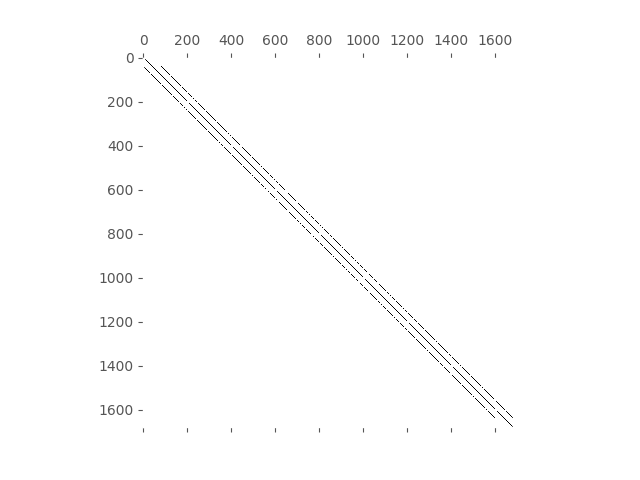

In [19]:
pyplot.figure()
pyplot.spy(A);

<IPython.core.display.Javascript object>


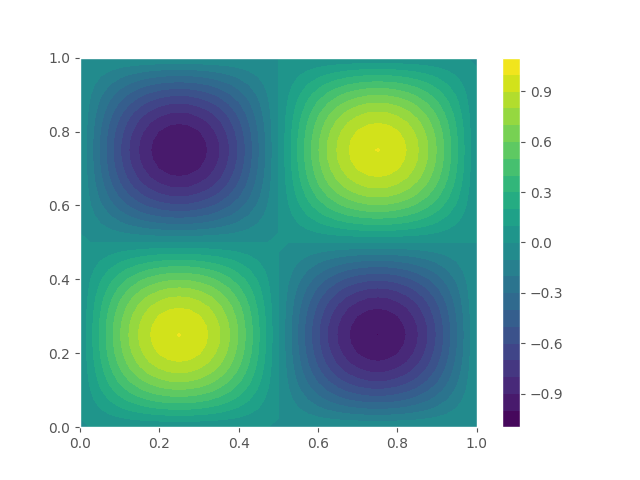

In [19]:
x = numpy.linalg.solve(A, rhs.flatten())
grid.contourf(x, levels=20)

Let's look at convergence. We conveniently picked a problem for which the exact solution is easy to compute

$$
u^*(x, y) = \sin(2\pi x)\sin(2\pi y).
$$

In [21]:
def mms_errors(ncell, f, g):
    errors = []
    for n in ncell:
        grid = Grid(n + 1, n + 1)
        A, rhs = laplacian(grid, f, g)
        u = numpy.linalg.solve(A, rhs.flatten())
        X, Y = grid.XY
        uexact = numpy.sin(2*numpy.pi*X)*numpy.sin(2*numpy.pi*Y)
        u = u.reshape(uexact.shape)
        error = u - uexact
        error = numpy.sqrt(grid.hx*grid.hy)*numpy.linalg.norm(error)
        errors.append(error)
    return errors

In [22]:
ncell = numpy.geomspace(4, 64, num=5, dtype=int)
errors = mms_errors(ncell, f, g)

<IPython.core.display.Javascript object>


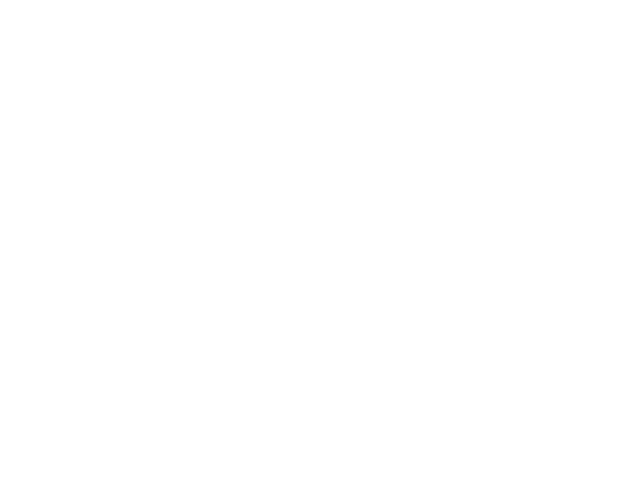

In [23]:
pyplot.figure()
pyplot.loglog(1/ncell, errors, "o", label="Numeric error")
pyplot.loglog(1/ncell, 1/ncell, label="$h^{-1}$")
pyplot.loglog(1/ncell, 1/ncell**2, label="$h^{-2}$")
pyplot.xlabel("$h$")
pyplot.ylabel("$\|u - u^*\|_2$")
pyplot.legend();

## Convergence order
We have 2nd order convergence. 

Notice that in 2D the grid-function norm is

$$
\|u\|_p = \left(h_x h_y \sum_i |u_i|^p\right)^{\frac{1}{p}}
$$

since we're a approximating a two-dimensional integral, and each little piece has area $h_x h_y$.

### Sparse matrices

We'd like to try on some bigger grids, but we run into a problem. The matrices we're making take a tremendously long time to invert. Let's see.

In [24]:
import cProfile, pstats
profiles = []
ncell = [40, 50, 60, 70, 80, 90, 100]
for n in ncell:
    prof = cProfile.Profile()
    prof.enable()
    grid = Grid(n+1, n+1)
    A, rhs = laplacian(grid, f, g)
    u = numpy.linalg.solve(A, rhs.flatten())
    prof.disable()
    profiles.append(prof)

In [25]:
for n, p in zip(ncell, profiles):
    print(f"***** Profile for {n}x{n} grid *****")
    pstats.Stats(p).sort_stats(pstats.SortKey.TIME).print_stats(3);

***** Profile for 40x40 grid *****
         10970 function calls (10961 primitive calls) in 0.122 seconds

   Ordered by: internal time
   List reduced from 81 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.098    0.098    0.098    0.098 /home/anne/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:314(solve)
        1    0.016    0.016    0.023    0.023 <ipython-input-17-82f0600fa69a>:1(laplacian)
     1521    0.003    0.000    0.005    0.000 <ipython-input-17-82f0600fa69a>:18(<listcomp>)


***** Profile for 50x50 grid *****
         17170 function calls (17161 primitive calls) in 0.871 seconds

   Ordered by: internal time
   List reduced from 81 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.830    0.830    0.830    0.830 /home/anne/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:314(solve)
        1    0.029    0.029    0.040    

Let's look at the *sparsity* of the operator again, and some statistics.

<IPython.core.display.Javascript object>


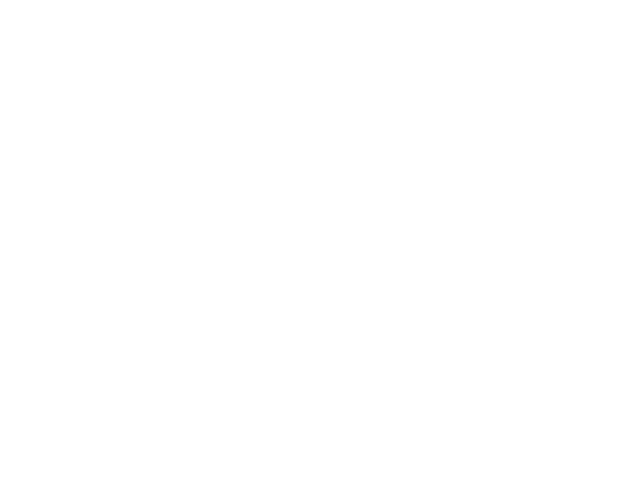

In [25]:
A, _ = laplacian(Grid(11, 11), f, g)
pyplot.figure()
#pyplot.spy(A);
Ainv = numpy.linalg.inv(A)
pyplot.spy(Ainv);

In [28]:
print(f"Percentage of nonzeros: {100*numpy.prod(Ainv[numpy.nonzero(Ainv)].shape) / numpy.prod(A.shape):0.2f}%")

Percentage of nonzeros: 83.94%


In [ ]:
print(f"Percentage of nonzeros: {100*numpy.prod(A[numpy.nonzero(Ainv)].shape) / numpy.prod(A.shape):0.2f}%")

### Speeding up the solve

So we're doing a lot of work storing lots of redundant zeros, and potentially lots of redundant work solving the equation.

Instead, we can use a *sparse* matrix, provided by scipy.

In [29]:
import scipy.sparse as sp
import scipy.sparse.linalg


def laplacian_sparse(grid, f, g):
    ndof = numpy.asarray(grid.ndof, dtype=int)
    A = sp.lil_matrix((ndof, ndof))
    X, Y = grid.XY
    u0 = g(X, Y)
    rhs = f(X, Y)
    mask = numpy.zeros_like(X, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    stencilx = 1/grid.hx**2 * numpy.array([-1, 0, 2, 0, -1])
    stencily = 1/grid.hy**2 * numpy.array([0, -1, 2, -1, 0])
    stencil = stencilx + stencily
    for i in range(grid.Nx):
        for j in range(grid.Ny):
            row = grid.alpha(i, j)
            if mask[row] == 0:
                # Dirichlet bc
                A[row, row] = 1
                rhs[i, j] = u0[i, j]
            else:
                stencili = numpy.asarray([grid.alpha(*ij) for ij in
                                          [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
                smask = mask[stencili]
                cols = stencili[smask == 1]
                A[row, cols] = stencil[smask == 1]
                # Lift boundary contribution to RHS
                bdycols = stencili[smask == 0]
                rhs[i, j] -= stencil[smask == 0] @ u0.reshape(-1)[bdycols]
    return A.tocsr(), rhs

<IPython.core.display.Javascript object>


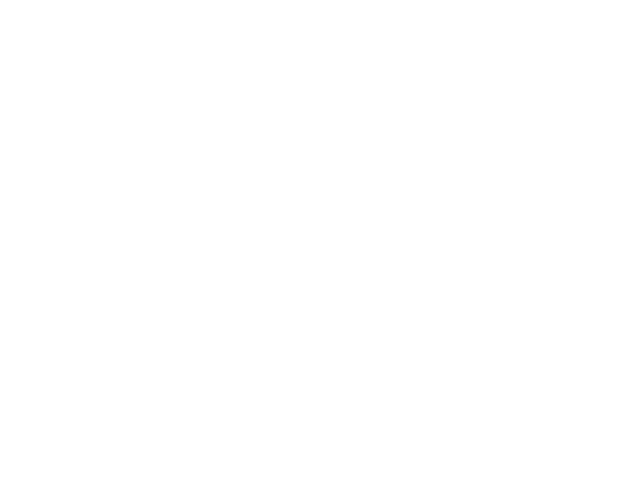

In [30]:
grid = Grid(41, 41)
A, rhs = laplacian_sparse(grid, f, g)
u = sp.linalg.spsolve(A, rhs.flatten(), use_umfpack=True)
grid.contourf(u, levels=20);

### Question

Check this solution actually converges at second order.

### Back to performance

In [31]:
import cProfile, pstats
profiles = []
ncell = [40, 50, 60, 70, 80, 80, 100]
for n in ncell:
    prof = cProfile.Profile()
    prof.enable()
    grid = Grid(n+1, n+1)
    A, rhs = laplacian_sparse(grid, f, g)
    u = sp.linalg.spsolve(A, rhs.flatten())
    prof.disable()
    profiles.append(prof)

In [32]:
for n, p in zip(ncell, profiles):
    print(f"***** Profile for {n}x{n} grid *****")
    pstats.Stats(p).sort_stats(pstats.SortKey.TIME).print_stats(3);

***** Profile for 40x40 grid *****
         222474 function calls (222463 primitive calls) in 0.262 seconds

   Ordered by: internal time
   List reduced from 145 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.038    0.038    0.258    0.258 <ipython-input-29-d591e0137344>:5(laplacian_sparse)
     3044    0.027    0.000    0.034    0.000 /home/anne/.local/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:114(_broadcast_to)
     1521    0.018    0.000    0.195    0.000 /home/anne/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:75(__setitem__)


***** Profile for 50x50 grid *****
         350474 function calls (350463 primitive calls) in 0.378 seconds

   Ordered by: internal time
   List reduced from 145 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.053    0.053    0.370    0.370 <ipython-input-29-d591e0137344>:5(laplacian_sparse)
     

#### A more efficient implementation

- creation of the matrix is the most expensive bit. 

Potential fix:
- create a CSR matrix directly
- jit it with numba. 
    - We need to refactor the code a little (to move the jittable region into a separate function).

#### A more efficient implementation

For a CSR matrix we need to guess how big our data structures will be. Since we will have at most 5 entries per row, the value and colidx arrays are five times the number of degrees of freedom (rows).

In [36]:
@numba.jit(nopython=True) # warn if we couldn't compile
def make_csr(stencil, mask, hx, hy, Nx, Ny, u0, rhs):
    ndof = Nx * Ny
    ai = numpy.zeros(ndof+1, dtype=numpy.int32)
    aj = numpy.zeros(ndof*5, dtype=numpy.int32)
    av = numpy.zeros(ndof*5, dtype=numpy.float64)

    ajptr = 0
    u0 = u0.flatten()
    for i in range(Nx):
        for j in range(Ny):
            row = i*Ny + j
            if mask[row] == 0:
                ai[row+1] = 1 + ai[row]
                aj[ajptr] = row
                av[ajptr] = 1
                ajptr += 1
                rhs[i, j] = u0[row]
            else:
                stencili = numpy.asarray([i_*Ny + j_ for (i_, j_) in
                                          [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
                smask = mask[stencili]
                cols = stencili[smask == 1]
                ncol = len(cols)
                ai[row+1] = len(cols) + ai[row]
                aj[ajptr:ajptr+ncol] = cols
                av[ajptr:ajptr+ncol] = stencil[smask == 1]
                ajptr += ncol
                # Lift boundary contribution to RHS
                bdycols = stencili[smask == 0]
                rhs[i, j] -= stencil[smask == 0] @ u0[bdycols]
    return ai, aj, av

In [37]:
def laplacian_sparse_csr(grid, f, g):
    ndof = numpy.asarray(grid.ndof, dtype=int)
    X, Y = grid.XY
    u0 = g(X, Y)
    rhs = f(X, Y)
    mask = numpy.zeros_like(X, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    stencilx = 1/grid.hx**2 * numpy.array([-1, 0, 2, 0, -1])
    stencily = 1/grid.hy**2 * numpy.array([0, -1, 2, -1, 0])
    stencil = stencilx + stencily
    ai, aj, av = make_csr(stencil, mask, grid.hx, grid.hy, grid.Nx, grid.Ny, u0, rhs)
    return sp.csr_matrix((av, aj, ai), shape=(ndof, ndof)), rhs

In [38]:
import cProfile, pstats
profiles = []
ncell = [40, 50, 60, 70, 80, 80, 100]
for n in ncell:
    prof = cProfile.Profile()
    prof.enable()
    grid = Grid(n+1, n+1)
    A, rhs = laplacian_sparse_csr(grid, f, g)
    u = sp.linalg.spsolve(A, rhs.flatten())
    prof.disable()
    profiles.append(prof)

In [39]:
for n, p in zip(ncell, profiles):
    print(f"***** Profile for {n}x{n} grid *****")
    pstats.Stats(p).sort_stats(pstats.SortKey.TIME).print_stats(3);

***** Profile for 40x40 grid *****
         1921496 function calls (1795345 primitive calls) in 2.667 seconds

   Ordered by: internal time
   List reduced from 2558 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3291    0.999    0.000    1.000    0.000 /home/anne/.local/lib/python3.8/site-packages/llvmlite/binding/ffi.py:111(__call__)
     4140    0.085    0.000    0.092    0.000 /home/anne/.local/lib/python3.8/site-packages/llvmlite/ir/values.py:120(__init__)
65886/12133    0.072    0.000    0.103    0.000 /home/anne/.local/lib/python3.8/site-packages/numba/core/ir.py:313(_rec_list_vars)


***** Profile for 50x50 grid *****
         273 function calls (262 primitive calls) in 0.011 seconds

   Ordered by: internal time
   List reduced from 107 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.007    0.007    0.007    0.007 {built-in method scipy.sparse.linalg.d

### Algorithmic performance of sparse direct solvers

Now, finally, the solve is back at the top of our profile. Let's see how it scales with the number of dofs.


### Algorithmic performance of sparse direct solvers
We split the work into three phases

1. Assembly of the operator (matrix $A$)
2. Factoring the matrix into sparse $LU$ form
3. Solving the problem by forward-backward substitution.


### Algorithmic performance of sparse direct solvers

For these sparse operators and the sparse direct solver we expect complexity

1. Assembly $\mathcal{O}(n)$
2. Factoring $\mathcal{O}(n^{3/2})$
3. Solve $\mathcal{O}(n \log n)$

In [40]:
import time
ns = numpy.geomspace(16, 512, num=7, dtype=numpy.int32)
factor_times = []
lu_solve_times = []
assemble_times = []
for n in ns:
    grid = Grid(n+1,n+1)
    start = time.time()
    A, rhs = laplacian_sparse_csr(grid, f, g)
    end = time.time()
    assemble_times.append(end - start)
    print(f"Assemble on {n}x{n} grid took {assemble_times[-1]:.2f}s")
    start = time.time() 
    lu = sp.linalg.splu(A.tocsc())
    end = time.time()
    factor_times.append(end - start)
    print(f"Factor on {n}x{n} grid took {factor_times[-1]:.2f}s")
    start = time.time()
    u = lu.solve(rhs.flatten())
    end = time.time()
    lu_solve_times.append(end - start)
    print(f"Solve on {n}x{n} grid took {lu_solve_times[-1]:.2f}s")

Assemble on 16x16 grid took 0.00s
Factor on 16x16 grid took 0.00s
Solve on 16x16 grid took 0.00s
Assemble on 28x28 grid took 0.00s
Factor on 28x28 grid took 0.00s
Solve on 28x28 grid took 0.00s
Assemble on 50x50 grid took 0.00s
Factor on 50x50 grid took 0.01s
Solve on 50x50 grid took 0.00s
Assemble on 90x90 grid took 0.01s
Factor on 90x90 grid took 0.04s
Solve on 90x90 grid took 0.00s
Assemble on 161x161 grid took 0.03s
Factor on 161x161 grid took 0.36s
Solve on 161x161 grid took 0.02s
Assemble on 287x287 grid took 0.15s
Factor on 287x287 grid took 2.21s
Solve on 287x287 grid took 0.07s
Assemble on 512x512 grid took 0.30s
Factor on 512x512 grid took 11.61s
Solve on 512x512 grid took 0.16s


<IPython.core.display.Javascript object>


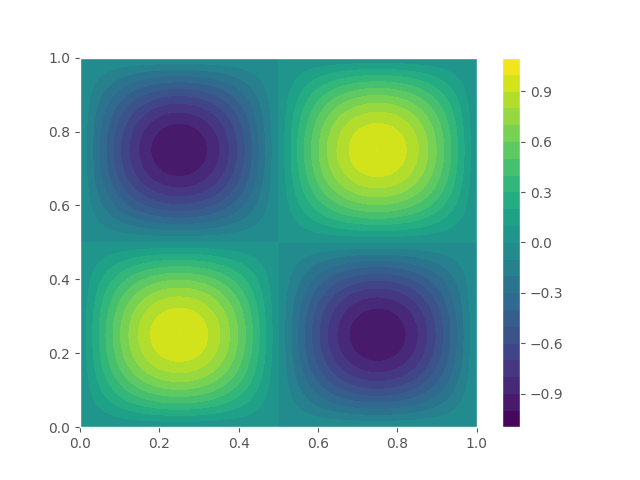

In [41]:
grid.contourf(u, levels=20);

<IPython.core.display.Javascript object>


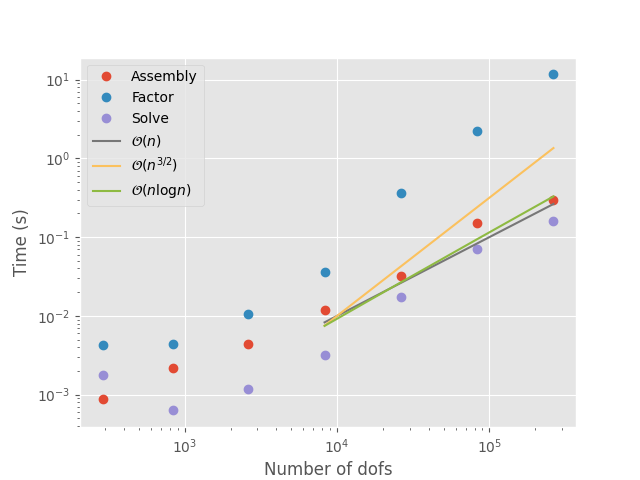

In [42]:
ndof = (ns+1)**2
pyplot.figure()
pyplot.loglog(ndof, assemble_times, "o", label="Assembly")
pyplot.loglog(ndof, factor_times, "o", label="Factor")
pyplot.loglog(ndof, lu_solve_times, "o", label="Solve")
ndof = ndof[3:]
pyplot.loglog(ndof, ndof/1e6, label="$\mathcal{O}(n)$")
pyplot.loglog(ndof, ndof**(3/2)/1e8, label="$\mathcal{O}(n^{3/2})$")
pyplot.loglog(ndof, ndof*numpy.log(ndof)/1e7, label="$\mathcal{O}(n \log n)$")
pyplot.xlabel("Number of dofs")
pyplot.ylabel("Time (s)")
pyplot.legend();

## Observations

- the factoring is clearly $n^{3/2}$, 
- assembly looks like it's $n$. 
- The solve itself is rather hard to judge, I suspect it's $n\log n$, but we're observing probably cache effects for the smaller problems.


## Outlook

- Optimally we would like to solve in $O(n)$ not $O(n^{3/2})$
- Next we look at some solvers that can achieve this